#**A Machine Learning Algorithm for Detection of Atrial Fibrillation**

In [0]:
!pip install peakutils
!pip install imblearn

  Running setup.py bdist_wheel for peakutils ... - done
  Stored in directory: /content/.cache/pip/wheels/69/27/3b/83a73e6893760f17246212c701ac5574035a75e18a30e87829
Successfully built peakutils
    100% |████████████████████████████████| 153kB 10.4MB/s 


In [0]:
from scipy.io import * 
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.interpolate import *
from scipy.signal import *
from sklearn.metrics import roc_curve, auc
from imblearn import over_sampling as imb

###**Clone in Data from Annie's Github and the model from Phil's Github**

In [0]:
!git clone https://github.com/liua13/BWSIFinalProject.git
os.chdir('./BWSIFinalProject') # change directory to repo containing training, validation, and testing data, as well as labels

Cloning into 'BWSIFinalProject'...
remote: Counting objects: 8553, done.
remote: Compressing objects: 100% (8552/8552), done.
remote: Total 8553 (delta 7), reused 8542 (delta 1), pack-reused 0
Receiving objects: 100% (8553/8553), 92.35 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (7/7), done.


###**Create a DataFrame from the .csv file that contains the labels**

In [0]:
labels = pd.read_csv("labels.csv", names = ['name', 'class'])
labels['class'] = labels['class'].replace('N', 0) # normal (no heart arrythmias)               
labels['class'] = labels['class'].replace('A', 1) # atrial fibrillation
labels['class'] = labels['class'].replace('O', 2) # other heart arrythmia(s)
labels['class'] = labels['class'].replace('~', 3) # signal too noisy to classify
labels = labels.drop(["name"], axis=1)
labels.head()

,class
0,0
1,0
2,0
3,1
4,1


###**Create a DataFrame from the .csv with the record file names**

In [0]:
df  = pd.read_csv('allrecords.csv', names = ['record name', 'signals', 'frequency', 'sample number', 'date','time','filename', 'format', 'baseline','adc', 'zeroes', 'initial value','check','block','description', 'NaNs'])
df = df.drop(['signals', 'frequency', 'format', 'baseline', 'filename', 'adc', 'zeroes', 'check', 'block', 'description', 'NaNs'], axis=1)
df['labels'] = labels['class']
df = df[df['labels'] != 3] # drop the "too noisy to classify" class
df= df.reset_index()
df.head()

,index,record name,sample number,date,time,initial value,labels
0,0,A00001,9000,2014-05-08,05:05:15,-127,0
1,1,A00002,9000,2014-05-16,11:05:25,128,0
2,2,A00003,18000,2014-04-15,12:04:05,56,0
3,3,A00004,9000,2014-05-01,11:05:48,519,1
4,4,A00005,18000,2013-12-23,08:12:08,-188,1


###**The following function loads in ten seconds of the specified signal, and downsamples it to 100 Hz (to match Neulog data)**

In [0]:
def get_sample_data(i):
    record = df.loc[i,'record name']
    recordnum = int(record[1:6])
    file = "./train" + str(((recordnum - 1)//1000) + 1) + '/' + record + '.mat' # direct into each file in training data
    a , b = butter(5,.05,'highpass') # create a butterworth filter
    sample = loadmat(file)["val"][0][0:3000:3] + np.random.normal(0,30,loadmat(file)["val"][0][0:3000:3].shape[0]) # add artificial noise to the sample
    sample = filtfilt(a,b,sample) # applies filter to data
    return sample

###**The following function creates an array of normalized ECG signals for us to pass through our model**

In [0]:
def signal_array(start,end):
  features = np.ndarray(shape = ((end-start), 1000)) #create the signal array of values from the sample
  for i in range(start, end):
    sample = get_sample_data(i) # get the sample using the above function
    
    if(len(sample) < 1000):
      features[i - start] = np.pad(sample, pad_width = (0,1000-len(sample)), mode = 'constant', constant_values = 0) # pad if the signal is less than 10 seconds long
    else:
      features[i - start] = sample[0:1000]
    
    features[i - start] = (features[i - start]-np.mean(features[i - start]))/np.std(features[i - start]) # normalization of data
   
  return features

###**Function for reshapeing data for SLAPNet Mark II**

In [0]:
def reshape_for_NN(arr):
  arr = arr.reshape(arr.shape[0], arr.shape[1], 1) # change shape of array to allow for proper input into NN
  return arr

###**Split Physionet 2017 Challenge data into train, validation, and test sets, and perform SMOTE over-sampling on the training set**

In [0]:
tv_data = signal_array(0, 8249) # get signal array for all of training data

ros = imb.SMOTE() # initialize oversampling method

X_train, X_val, y_train, y_val = train_test_split(tv_data[0:7248], df['labels'][0:7248], test_size = .25) # split data into training, validation, and test sets

X_train, y_train = ros.fit_sample(X_train, y_train) # oversample data to balance classes

X_train, X_val = reshape_for_NN(X_train), reshape_for_NN(X_val) # reshape array for input into NN

y_train, y_val = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_val) # convert labels into proper format for NN verification of predictions

test_data = reshape_for_NN(tv_data[7248:8249])
test_labels = tf.keras.utils.to_categorical(df['labels'][7248:8249], num_classes = 3)

###**Define and load in SLAPNet Mark II - our convolutional neural network (CNN)**

In [0]:
!git clone https://github.com/PhilMathew/BWSINN.git

Cloning into 'BWSINN'...
remote: Counting objects: 15, done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [0]:
os.chdir('./BWSINN')
def create_model(): # create an NN of three 1D convolution layers, which are alternated with average pooling layers
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape = (1000,1)))
  model.add(tf.keras.layers.Conv1D(128, kernel_size= 100, activation = tf.nn.relu))
  model.add(tf.keras.layers.AveragePooling1D(pool_size=2 , strides=None, padding='valid', data_format=None))
  model.add(tf.keras.layers.Conv1D(128, kernel_size= 5, activation = tf.nn.relu))
  model.add(tf.keras.layers.AveragePooling1D(pool_size=2 , strides=None, padding='valid', data_format=None))
  model.add(tf.keras.layers.Conv1D(64, kernel_size= 3, activation = tf.nn.relu))
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dropout(.25))
  model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax)) # output layer
  return model
  
model = create_model()
model.load_weights('SLAPNet_MkII.h5') # load in weights from SLAPNet Mark II
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) # compile with the necessary optimizer and loss function
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 901, 128)          12928     
_________________________________________________________________
average_pooling1d (AveragePo (None, 450, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 446, 128)          82048     
_________________________________________________________________
average_pooling1d_1 (Average (None, 223, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 221, 64)           24640     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
__________

###**Uses model to predict outcomes on test data**

In [0]:
neulog_predict = model.predict(test_data)

###**Display Accuracy and Confusion Matrix**

Accuracy: 0.6903096903096904
[[0.87783595 0.04712042 0.07504363]
 [0.17142857 0.68571429 0.14285714]
 [0.43034056 0.21052632 0.35913313]]


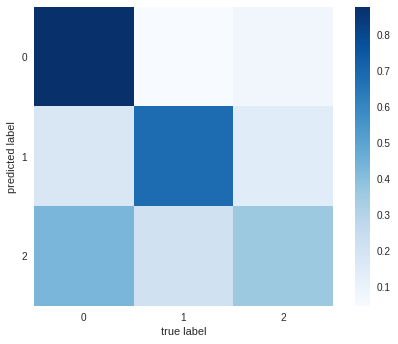

In [0]:
from sklearn import metrics
print('Accuracy:',metrics.accuracy_score(np.argmax(test_labels, axis = 1),np.argmax(neulog_predict, axis=1))) # print the accuracy of the model's predictions
cm = metrics.confusion_matrix(np.argmax(test_labels, axis = 1),np.argmax(neulog_predict, axis=1), labels = [0,1,2]) # create the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the confusion matrix
print(cm)
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues) # display the confusion matrix
plt.colorbar()
plt.xticks(np.arange(0,3, step = 1))
plt.yticks(np.arange(0,3,step = 1))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.grid(False)

###**Display ROC Curves and calculate average AUC**

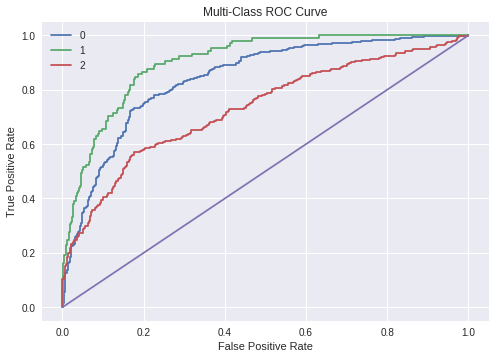

0.8579497425651272


In [0]:
y_pred = model.predict_proba(test_data) # predict probabilities on test data using model

fpr = {} # false positive rate
tpr = {} # true positive rate
roc_auc = {} # area under the roc curve

for i in range(3):
  
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels[:, i], y_pred[:, i]) # calculate fpr and tpr of model's predictions on test data
    roc_auc[i] = metrics.auc(fpr[i], tpr[i]) # calculate area under the roc curve using fpr and tpr
    plt.plot(fpr[i], tpr[i], label = str(i))
    
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels.ravel(), y_pred.ravel())
roc_auc = metrics.auc(fpr["micro"], tpr["micro"])
print(roc_auc)

##**Running the model on Neulog Data**

###**Upload Neulog ECG signal to notebook for running through model**

In [0]:
up = files.upload()

for i in up:
  filename = i
print(filename)

Saving yeet2.csv to yeet2.csv
yeet2.csv


###**Load the Neulog ECG signal into a numpy array, then run the model on the signal after filtering and normalization**

In [0]:
df2 = pd.read_csv(filename) # read Neulog ECG signal
df2 = df2.drop(df2.index[1007:1009]) # drop any parts of .csv file that aren't datapoints
df2 = df2.drop(df2.index[0:6]) # drop any parts of .csv file that aren't datapoints

neu = np.array(df2[str(filename[0:-4])]).astype('float')
a , b = butter(5, .05, 'highpass') 
neu = filtfilt(a, b, neu) # apply butterworth filter to data
neu = (neu - np.mean(neu))/np.std(neu) # normalize data
neu = neu[0:1000].reshape(1, 1000, 1) # reshape neulog data array to allow for passing into model

pred = np.argmax(model.predict(neu), axis = 1) # make prediction on Neulog data

if(pred == 1): # class 1 -----> atrial fibrillation
  pred = 'Atrial Fibrillation Detected'
elif(pred == 2): # class 2 -----> other heart arrythmia(s)
  pred = 'No Atrial Fibrillation Detected, but Signs of Other Arrhythmia Detected'
else: # class 0 -----> no heart arrythmias
  pred = 'No Signs of Heart Arrythmia Detected'
  
print(pred)

No Signs of Heart Arrythmia Detected


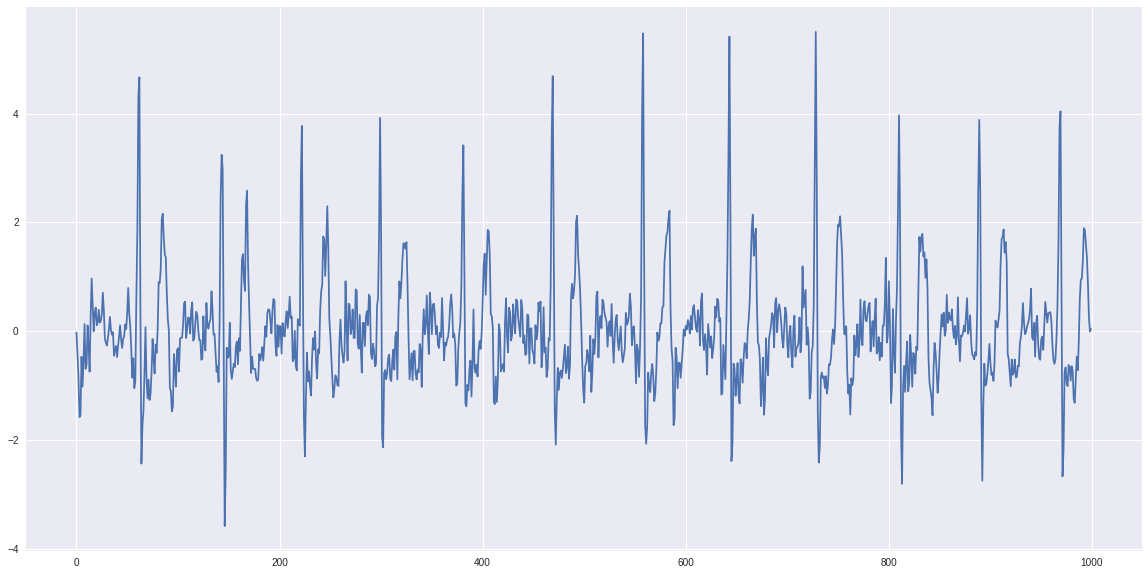

In [0]:
plt.figure(figsize = (20,10))
plt.plot(neu.reshape(1000,)) # plot filtered and normalized Neulog signal

###**Print the probabilities that the model predicted for each of the classes, for the ECG signal**

In [0]:
model.predict_proba(neu)

array([[9.7933906e-01, 3.5081041e-06, 2.0657409e-02]], dtype=float32)